# Quantum Excess Evaluation Algorithm [Development and Testing Notebook]
Implementing [Quantum Computational Insurance and Actuarial Science](https://arxiv.org/html/2410.20841v1#S7.SS1)

In [1]:
# %pip install --force-reinstall -v "qiskit==1.4.2"
# %pip install qiskit-ibm-runtime --upgrade
# %pip install qiskit[visualization] --upgrade
# %pip install qiskit[all] --upgrade
# %pip install qiskit_aer --upgrade
# %pip install qiskit_algorithms --upgrade
# %pip install pylatexenc --upgrade

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qiskit

qiskit.__version__

'1.4.2'

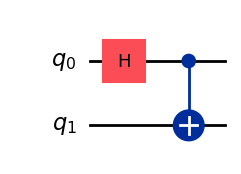

In [3]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)

qc.draw(output='mpl')

In [4]:

from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')

observables = [ZZ, ZI, IZ, XX, XI, IX]

In [5]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()

EstimatorResult(values=array([ 1.        , -0.0234375 , -0.0234375 ,  1.        , -0.00976562,
       -0.00976562]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0072287, 'sample_measure_time': 0.0016123, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 14181, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.99945068359375, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0072287, 'sample_measure_time': 0.001612

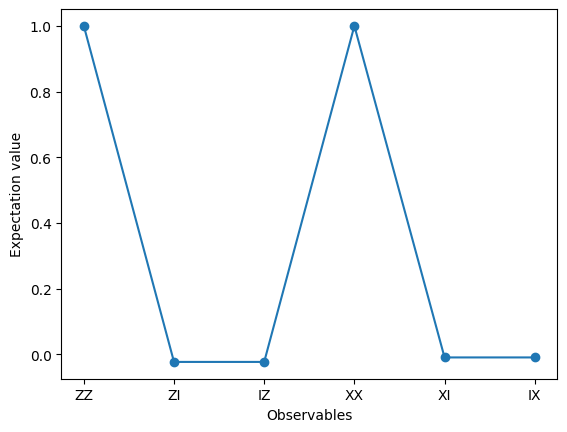

In [6]:
import matplotlib.pyplot as plt

data = ['ZZ', 'ZI', 'IZ', 'XX', 'XI', 'IX']
values = job.result().values

plt.plot(data, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Expectation value')
plt.show()

## Prepare State

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import StatePreparation
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from scipy.stats import lognorm

# Parameters
num_qubits = 4  # Using 6 qubits for demonstration, scalable approach
domain_min = 0
domain_max = 10
deductible = 2.0  # Deductible amount
coins = 0.4
c_param = 0.5 / (domain_max - deductible) # <-- keep in sync with apply_excess_rotations

# Define lognormal distribution parameters
sigma = 1.0  # Shape parameter
mu = 0.0     # Scale parameter

def lognormal_loss(x):
    """Lognormal loss function"""
    return lognorm.pdf(x, sigma, loc=0, scale=np.exp(mu))

# Discretize domain into 2^num_qubits points
N = 2**num_qubits
mid_step = (domain_max - domain_min) / (N - 1)
# Take the midpoint integral approximation to work on small number of qubits
mid_x_vals = np.linspace(
    domain_min + mid_step / 2,
    domain_max - mid_step / 2,
    N
)
step = mid_x_vals[1] - mid_x_vals[0]
probabilities = np.array([lognormal_loss(x) * step for x in mid_x_vals])
probabilities /= probabilities.sum()

# Full distribution for visualization
full_sims = 10_000
full_x_vals = np.linspace(domain_min, domain_max, full_sims)
full_step = (domain_max - domain_min) / (full_sims - 1)
full_mid_vals = np.linspace(
    domain_min + full_step / 2,
    domain_max - full_step / 2,
    full_sims
)
full_probabilities = np.array([lognormal_loss(x) * full_step for x in full_mid_vals])
full_probabilities /= full_probabilities.sum()

# Calculate amplitudes (square root of probabilities)
amplitudes = np.sqrt(probabilities)

# Create quantum circuit for state preparation
qc = QuantumCircuit(num_qubits)
qc.append(StatePreparation(amplitudes), range(num_qubits))

# Visualize the circuit (truncated for readability)
# qc.draw(output='mpl')

# Transpile the circuit to basic gates that Aer supports
qc = transpile(qc, basis_gates=['u3', 'cx'])
# qc.draw(output='mpl')

In [8]:
print(f"grid: {mid_x_vals}")
grid_space = mid_x_vals[1] - mid_x_vals[0]
print(f"grid space: {grid_space}")
print(f"step: {step}")

grid: [0.33333333 0.95555556 1.57777778 2.2        2.82222222 3.44444444
 4.06666667 4.68888889 5.31111111 5.93333333 6.55555556 7.17777778
 7.8        8.42222222 9.04444444 9.66666667]
grid space: 0.6222222222222222
step: 0.6222222222222222


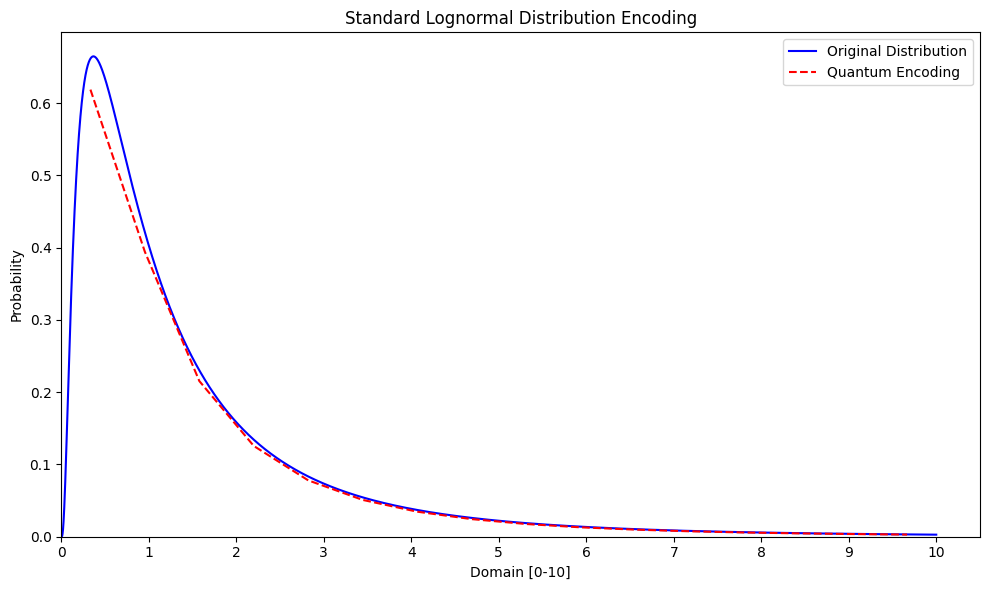

In [9]:
# Validate our state preparation by measuring
backend = Aer.get_backend('statevector_simulator')
statevector = backend.run(qc).result().get_statevector()

# Calculate the resulting probabilities
measured_probs = np.abs(statevector)**2

# Plot the original distribution vs quantum encoded distribution
plt.figure(figsize=(10, 6))
plt.plot(full_x_vals, full_probabilities / full_step, 'b-', label='Original Distribution')
plt.plot(mid_x_vals, measured_probs / step, 'r--', label='Quantum Encoding')
plt.xlabel('Domain [0-10]')
plt.ylabel('Probability')
plt.xticks(np.arange(domain_min, domain_max + 1, 1))
plt.title('Standard Lognormal Distribution Encoding')
plt.legend()
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()

# # Display the first few amplitudes
# print("First 10 amplitudes:")
# for i in range(10):
#     print(
#         f"State |{i}⟩: √p_j = {amplitudes[i]:.6f}, p_j = {probabilities[i]:.6f}")

### Plot State Degeneration With Decreased Qubits

In [10]:
# num_qubits_list = range(2, 8)
# N_list = [2**n for n in num_qubits_list]
# step_list = [(domain_max - domain_min) / (N - 1) for N in N_list]
# # Take the midpoint integral approximation to work on small number of qubits
# mid_x_vals_list = [np.linspace(domain_min + step / 2, domain_max - step / 2, N) for N in N_list]
# probabilities_list = []
# for i, N in enumerate(N_list):
#     x_vals = mid_x_vals_list[i]
#     step = step_list[i]
#     probabilities = np.array([lognormal_loss(x) * step for x in x_vals])
#     probabilities /= probabilities.sum()
#     probabilities_list.append(probabilities)

# # Add Color
# cmap = plt.cm.get_cmap('Reds', len(num_qubits_list) + 2)

# # Plot the original distribution vs quantum encoded distribution
# plt.figure(figsize=(10, 6))
# plt.plot(full_x_vals, full_probabilities / full_step, 'b-', label='Original Distribution')
# for i, N in enumerate(num_qubits_list):
#     x_vals = mid_x_vals_list[i]
#     step = step_list[i]
#     probabilities = probabilities_list[i]
#     alpha = 1/(i/2 + 1)
#     plt.plot(x_vals, probabilities / step, 'r-', alpha=alpha, label=f'Quantum Encoding ({N} qubits)')
# plt.xlabel('Domain [0-10]')
# plt.ylabel('Probability')
# plt.xticks(np.arange(domain_min, domain_max + 1, 1))
# plt.title('Loss Distribution Degeneration')
# plt.legend()
# plt.tight_layout()
# plt.axis([0, None, 0, None])
# plt.show()

# # # Display the first few amplitudes
# # print("First 10 amplitudes:")
# # for i in range(10):
# #     print(
# #         f"State |{i}⟩: √p_j = {amplitudes[i]:.6f}, p_j = {probabilities[i]:.6f}")

### Diagnostic

## Implement Quantum Subtraction

In [11]:
threshold_idx = np.searchsorted(mid_x_vals, deductible, side="left")
print(f"threshold = {threshold_idx}")
print(f"binary threshold = {threshold_idx:0{num_qubits}b}")

# def reverse_bits(k: int, n: int) -> int:
#     """
#     Fix qubit reference since IBM is little-endian (in fact that doesn't seem to be the case).
#     Reverse the bits of `k` in a binary representation of length `n`.
#     """
#     b = f"{k:0{n}b}"
#     return int(b[::-1], 2)

# threshold_rev = reverse_bits(threshold_idx, num_qubits)
# print(f"little-endian binary threshold = {threshold_rev:0{num_qubits}b}")

threshold = 3
binary threshold = 0011


### Endianness Diagnostic

In [12]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import StatePreparation
from qiskit.circuit.library.arithmetic.integer_comparator import IntegerComparator
from qiskit.quantum_info import Statevector


def test_endianness():
    # 1. Build the state-prep circuit
    loss_q = QuantumRegister(num_qubits, "x")
    qc_prep = QuantumCircuit(loss_q)
    qc_prep.append(StatePreparation(amplitudes), loss_q)

    # 2. Prepare registers for the comparator test
    flag_q = QuantumRegister(1,             "flag")
    wcmp_q = QuantumRegister(num_qubits-1,  "wcmp")
    qc = qc_prep.copy()
    qc.add_register(flag_q, wcmp_q)

    # 3. Define the comparator gate
    cmp_gate = IntegerComparator(num_state_qubits=num_qubits,
                                    value=threshold_idx,
                                    geq=True)

    # 4. Try both orderings
    print("classical tail =", probabilities[threshold_idx:].sum())
    for name, order in [("MSB→LSB",       list(loss_q)),
                        ("LSB→MSB (rev)", list(reversed(loss_q)))]:
        qc_test = qc.copy()
        qc_test.append(cmp_gate,
                        order         # try one of the two
                        + [flag_q[0]]  # then the flag
                        + list(wcmp_q))  # then the workspace
        p_flag = Statevector.from_instruction(qc_test) \
            .probabilities_dict(qargs=[qc_test.qubits.index(flag_q[0])]) \
            .get('1', 0)
        print(f"{name:>12} ordering →  P(flag=1) = {p_flag:.6f}")


test_endianness()

classical tail = 0.23567336384650622
     MSB→LSB ordering →  P(flag=1) = 0.235673
LSB→MSB (rev) ordering →  P(flag=1) = 0.555516


In [13]:
from qiskit.quantum_info import Statevector

loss_q = QuantumRegister(num_qubits, "x")
qc_prep = QuantumCircuit(loss_q)
qc_prep.append(StatePreparation(amplitudes), loss_q)

# Get the statevector after the state preparation.
sv = Statevector.from_instruction(qc_prep)

# Print amplitudes for all basis states.
for i, amplitude in enumerate(sv.data):
    print(f"State |{i:0{num_qubits}b}>: probability = {abs(amplitude)**2}")

State |0000>: probability = 0.3849885363911533
State |0001>: probability = 0.2453055828607604
State |0010>: probability = 0.13403251690158188
State |0011>: probability = 0.0781621789217161
State |0100>: probability = 0.048536811445241516
State |0101>: probability = 0.03170651641406825
State |0110>: probability = 0.02156981690743417
State |0111>: probability = 0.015166140093950942
State |1000>: probability = 0.010958954605017395
State |1001>: probability = 0.008103094529409131
State |1010>: probability = 0.006110292505708725
State |1011>: probability = 0.004686497279638885
State |1100>: probability = 0.0036482217591824145
State |1101>: probability = 0.002877410159364484
State |1110>: probability = 0.0022960521946904593
State |1111>: probability = 0.0018513770310844358


In [14]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RZGate, RYGate
from qiskit.circuit.library.data_preparation.state_preparation import StatePreparation
from qiskit.circuit.library.basis_change.qft import QFT
from qiskit.circuit.library.arithmetic.integer_comparator import IntegerComparator
from qiskit.quantum_info import Statevector


print("x_vals head:", mid_x_vals[:5])
print("x_vals tail:", mid_x_vals[-5:])
print("deductible d =", deductible)

def make_subtractor(loss_reg, constant) -> QuantumCircuit:
    """
    Quantum circuit that maps |x> -> |x - constant mod 2^n>
    on `loss_reg`.

    Parameters
    ----------
    loss_reg : QuantumRegister (or list of Qubits)
        Register that stores an unsigned integer.
    constant : int
        Positive integer < 2^n to subtract.
    """
    n  = len(loss_reg)
    qc = QuantumCircuit(loss_reg, name=f"-{constant}")

    # 1) Reverse into little-endian
    rev = loss_reg[::-1]

    # 2) QFT (decomposed → gate)
    qft_circ = QFT(num_qubits=n, do_swaps=False)
    qft_decomp = qft_circ.decompose()
    qft_decomp = transpile(qft_decomp,
                            basis_gates=['u', 'cx'],
                            optimization_level=3)
    qft_gate   = qft_decomp.to_gate(label="QFT_decomp")
    qc.append(qft_gate, rev)

    # 3) Phase shift: subtract constant via phases
    for k, qb in enumerate(rev):
        angle = -2 * np.pi * constant / (2 ** (k + 1))
        qc.rz(angle, qb)

    # 4) Inverse QFT (decomposed → gate)
    inv_circ   = QFT(num_qubits=n, do_swaps=False).inverse()
    inv_decomp = inv_circ.decompose()
    inv_decomp = transpile(inv_decomp,
                            basis_gates=['u', 'cx'],
                            optimization_level=3)
    inv_gate = inv_decomp.to_gate(label="QFT_inv")
    qc.append(inv_gate, rev)

    # 5) Reverse back to MSB-first
    for i in range(n // 2):
        qc.swap(loss_reg[i], loss_reg[n - 1 - i])

    return qc


print("⦿ classical P(X≥ded) =", probabilities[threshold_idx:].sum())

# 1) State-prep
x_q = QuantumRegister(num_qubits, "x") # loss register
qc  = QuantumCircuit(x_q) # create a new circuit, overwrite the old one
qc.append(StatePreparation(amplitudes), x_q) # state-prep circuit

# 2) Comparator → flag  (MSB→LSB)
flag_q = QuantumRegister(1, "flag") # flag for comparator
wcmp_q = QuantumRegister(num_qubits-1, "wcmp") # workspace for comparator
qc.add_register(flag_q, wcmp_q) # add registers to circuit

# Define the comparator gate (compare to a constant)
cmp_gate = IntegerComparator(num_state_qubits=num_qubits,
                            value=threshold_idx,
                            geq=True)

# MSB→LSB: list(x_q) is MSB, list(reversed(x_q)) is LSB
# Append the comparator gate to the circuit
qc.append(cmp_gate,
        list(x_q)      # MSB→LSB
        + [flag_q[0]]  # then the flag
        + list(wcmp_q))

# sanity-check the comparator alone
sv     = Statevector.from_instruction(qc)
f_idx  = qc.qubits.index(flag_q[0])
p_flag = sv.probabilities_dict(qargs=[f_idx]).get('1', 0)
print("⦿ quantum  P(flag=1) =", p_flag)

# 3) QFT-subtractor (controlled on the same flag)
#   subtract threshold mod 2^n via phases in the QFT basis
sub_circ = make_subtractor(x_q, threshold_idx)
sub_gate = sub_circ.to_gate(label="qft_subtractor") # convert to gate
# Create a controlled version of the subtractor gate.
# The subtraction only happens if the single control qubit is in state |1>,
# leaving it unchanged otherwise.
csub_gate = sub_gate.control(1)
# Append the controlled subtractor gate to the circuit
qc.append(csub_gate, [flag_q[0]] + list(x_q))

# 4) Process the excess
# Ancilla qubits are extra qubits added to a quantum circuit
# to facilitate certain operations or algorithms.
payout_aux = QuantumRegister(1, "payout_aux")
qc.add_register(payout_aux)

# And encode the excess into the ancilla:
for i, qb in enumerate(list(x_q)):
    # The angle of the rotation is proportional to the excess
    # and the qubit index (2^i).
    angle = -2 * np.pi * c_param * (2**i) # weights = 1, 2, 4, 8 for a 4-qubit reg
    # Build a 2-control RY(angle):
    cry2 = RYGate(angle).control(2)         
    # The first control is the flag, the second is the qubit.
    qc.append(cry2, [flag_q[0], qb, payout_aux[0]])
    
    # And the matching phase‐correction RZ(angle):
    # Build a 2-control RZ(angle):
    # The angle is the same as above.
    # The first control is the flag, the second is the qubit.
    crz2 = RZGate(angle).control(2)
    qc.append(crz2, [flag_q[0], qb, payout_aux[0]])

# 5) Uncompute the ancillas of the first comparator
# We need to uncompute the ancillas of the first comparator
# to get back to the original state.
# We need to add an auxiliary qubit to store the flag.
aux_flag = QuantumRegister(1, "aux_flag")
qc.add_register(aux_flag)

# The CX (controlled-X) gate flips the target qubit
# only if the control qubit is in the |1⟩ state,
# and leaves it unchanged if the control qubit is |0⟩.
qc.cx(flag_q[0], aux_flag[0])

# Uncompute the ancillas of the first comparator
qc.append(cmp_gate,
        list(x_q) # data bits
        + [aux_flag[0]]
        + list(wcmp_q))

# Final sanity-check
sv2    = Statevector.from_instruction(qc)
p_flag2 = sv2.probabilities_dict(qargs=[f_idx]).get('1', 0)
print("⦿ after QFT-sub, P(flag=1) =", p_flag2)

print("Payout ancilla index should be:", qc.qubits.index(payout_aux[0]))

# 4) (optional) controlled-rotations + measurement
# from here you can call add_measure_qubit_and_bias(qc) and
# apply_excess_rotations(qc, x_q, flag_q[0], meas_q[0], step, c_param)
# then measure and back-out the expected payment.  

# Your P(flag=1) should now be ~0.5062, and your final E[payment] ~0.34.

x_vals head: [0.33333333 0.95555556 1.57777778 2.2        2.82222222]
x_vals tail: [7.17777778 7.8        8.42222222 9.04444444 9.66666667]
deductible d = 2.0
⦿ classical P(X≥ded) = 0.23567336384650622
⦿ quantum  P(flag=1) = 0.23567336384650692
⦿ after QFT-sub, P(flag=1) = 0.23567336384650717
Payout ancilla index should be: 8


In [15]:
for inst in qc.data:
    if inst.operation.name in ("cry","rz"):
        print(inst.operation.name, inst.operation.params[0], "→", [qc.qubits.index(q) for q in inst.qubits])

In [16]:
def smoke_test_pure_subtractor(n, threshold_idx):
    for x in range(2**n):
        reg = QuantumRegister(n, "x")
        qc  = QuantumCircuit(reg)
        # prepare |x>
        for j in range(n):
            if (x >> (n-1-j)) & 1:
                qc.x(reg[j])
        qc.append(make_subtractor(reg, threshold_idx), reg)
        # check on data register only (ignore ancilla)
        sv  = Statevector.from_instruction(qc)
        data_qargs = [qc.qubits.index(qb) for qb in reg]
        probs = sv.probabilities_dict(qargs=data_qargs)
        out = max(probs, key=probs.get)
        got = int(out, 2)
        want = (x - threshold_idx) % (2**n)
        if got != want:
            print(f"FAIL: x={x:02d} → got {got:02d} ({got:04b}₂), expected {want:02d} ({want:04b}₂)")
            return
    print("✅ subtractor matches classical arithmetic for all inputs")


smoke_test_pure_subtractor(num_qubits, threshold_idx)

✅ subtractor matches classical arithmetic for all inputs


In [17]:
def smoke_test_controlled_subtractor(n, threshold_idx):
    for x in range(2**n):
        # ── build a fresh 5-qubit circuit ─────────────────────────────────
        flag = QuantumRegister(1,  "flag")
        reg = QuantumRegister(n,  "x")
        qc_c = QuantumCircuit(flag, reg)

        # 1) set flag = |1⟩ so the controlled-subtractor actually runs
        qc_c.x(flag[0])

        # 2) prepare |x⟩ on the data register
        for j in range(n):
            if (x >> (n-1-j)) & 1:
                qc_c.x(reg[j])

        # 3) append the 5-qubit controlled-subtractor
        sub_gate = make_subtractor(reg, threshold_idx).to_gate()
        csub_gate = sub_gate.control(1)
        qc_c.append(csub_gate, [flag[0]] + list(reg))

        # 4) simulate and read out just the data bits
        sv = Statevector.from_instruction(qc_c)
        data_qargs = [qc_c.qubits.index(qb) for qb in reg]
        probs = sv.probabilities_dict(qargs=data_qargs)
        out = max(probs, key=probs.get)
        got = int(out, 2)
        want = (x - threshold_idx) % (2**n)

        if got != want:
            print(
                f"FAIL: x={x:02d} → got {got:02d} ({got:0{n}b}), expected {want:02d} ({want:0{n}b})")
            return

    print("✅ controlled-subtractor matches classical arithmetic for all inputs")


smoke_test_controlled_subtractor(num_qubits, threshold_idx)

✅ controlled-subtractor matches classical arithmetic for all inputs


In [18]:
def check_subtractor(n, const, big_endian=False):
    # 1) Create just the data register and build the circuit
    reg = QuantumRegister(n, "x")
    qc = QuantumCircuit(reg)

    # 2) Initialize to all 1’s: |111…1>
    qc.x(reg)

    # 3) Decide ordering for make_subtractor
    if big_endian:
        qs = reg                 # MSB→LSB
    else:
        qs = reg[::-1]           # LSB→MSB

    # 4) Append the pure 4-qubit subtractor on exactly those n qubits
    qc.append(make_subtractor(qs, const), list(qs))

    # 5) Grab the output state and show only amplitudes >1%
    bits = Statevector.from_instruction(qc).probabilities_dict()
    filtered = {k: v for k, v in bits.items() if v > 0.01}

    # 6) Print results
    start = 2**n - 1
    want = (start - const) % (2**n)
    print(f"Starting state: |{'1'*n}⟩ (decimal: {start})")
    print(f"Subtracting: {const}")
    print(f"Expected result: |{want:0{n}b}⟩ (decimal: {want})")
    print("Actual result (states with probability > 0.01):")
    for state, prob in filtered.items():
        print(f"  |{state}⟩: {prob:.6f} (decimal: {int(state, 2)})")
    print("─" * 30)


# Run your checks:
check_subtractor(num_qubits, 1, big_endian=True)
check_subtractor(num_qubits, 2, big_endian=True)
check_subtractor(num_qubits, 3, big_endian=True)

Starting state: |1111⟩ (decimal: 15)
Subtracting: 1
Expected result: |1110⟩ (decimal: 14)
Actual result (states with probability > 0.01):
  |1110⟩: 1.000000 (decimal: 14)
──────────────────────────────
Starting state: |1111⟩ (decimal: 15)
Subtracting: 2
Expected result: |1101⟩ (decimal: 13)
Actual result (states with probability > 0.01):
  |1101⟩: 1.000000 (decimal: 13)
──────────────────────────────
Starting state: |1111⟩ (decimal: 15)
Subtracting: 3
Expected result: |1100⟩ (decimal: 12)
Actual result (states with probability > 0.01):
  |1100⟩: 1.000000 (decimal: 12)
──────────────────────────────


In [19]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import StatePreparation
import numpy as np

def test_subtractor(num_qubits, threshold_idx, prob):
    # --- 1) Real circuit under test (flag + loss only) ---
    flag = QuantumRegister(1,       "flag")
    loss = QuantumRegister(num_qubits, "x")
    qc_subtest = QuantumCircuit(flag, loss)

    # Load the distribution onto loss (MSB→LSB)
    qc_subtest.append(StatePreparation(np.sqrt(prob)), loss[::-1])
    qc_subtest.x(flag[0])

    # Build and append the 5-qubit controlled-subtractor
    sub_gate = make_subtractor(loss, threshold_idx).to_gate()
    csub_gate = sub_gate.control(1)
    # **exactly** 1 flag + n loss qubits
    qc_subtest.append(csub_gate, [flag[0]] + list(loss))

    # Simulate
    sv2 = Statevector.from_instruction(qc_subtest)
    sv2_probs = np.abs(sv2.data)**2

    # --- 2) Operator-based expected state (flag + loss only) ---
    qc_init = QuantumCircuit(flag, loss)
    qc_init.append(StatePreparation(np.sqrt(prob)), loss[::-1])
    qc_init.x(flag[0])
    psi0 = Statevector.from_instruction(qc_init)

    Ucsub = Operator(csub_gate)          # shape 2^(n+1)×2^(n+1)
    psi_exp = Ucsub.data @ psi0.data
    exp_probs = np.abs(psi_exp)**2

    # --- 3) Compare ---
    print("subtract correct:", np.allclose(sv2_probs, exp_probs, atol=1e-8))
    for idx, (p_act, p_exp) in enumerate(zip(sv2_probs, exp_probs)):
        if not np.isclose(p_act, p_exp, atol=1e-8):
            bitstr = format(idx, f'0{num_qubits+1}b')
            print(
                f"mismatch at index {bitstr}: actual {p_act:.6f} vs expected {p_exp:.6f}")


test_subtractor(num_qubits, threshold_idx, probabilities)

subtract correct: True


In [20]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
import numpy as np

def test_subtractor_full(n, thr):
    for j in range(2**n):
        # 1) fresh flag + data registers
        flag_q = QuantumRegister(1, "flag")
        x_q    = QuantumRegister(n, "x")
        qc     = QuantumCircuit(flag_q, x_q)

        # 2) set flag = |1>
        qc.x(flag_q[0])

        # 3) prepare |j> on the data register
        for i, bit in enumerate(format(j, f"0{n}b")):
            if bit == '1':
                qc.x(x_q[i])

        # 4) append the 5-qubit controlled-subtractor
        sub_gate  = make_subtractor(x_q, thr).to_gate(label="qft_subtractor")
        csub_gate = sub_gate.control(1)
        qc.append(csub_gate, [flag_q[0]] + list(x_q))

        # 5) simulate and read out just the data bits
        sv = Statevector.from_instruction(qc)
        data_idxs = [qc.qubits.index(q) for q in x_q]
        probs     = sv.probabilities_dict(qargs=data_idxs)

        # pick the most likely outcome
        got_str = max(probs, key=probs.get)
        got     = int(got_str, 2)

        want = (j - thr) % (2**n)
        if got != want:
            print(f"ERROR: j={j}, expected={want} ({want:0{n}b}), got={got} ({got:0{n}b})")
            return
        else:
            print(f"OK:    j={j} → {got} ({got:0{n}b})")

    print("✅ All basis states verified for controlled subtractor")

# Run the test!
test_subtractor_full(num_qubits, threshold_idx)


OK:    j=0 → 13 (1101)
OK:    j=1 → 14 (1110)
OK:    j=2 → 15 (1111)
OK:    j=3 → 0 (0000)
OK:    j=4 → 1 (0001)
OK:    j=5 → 2 (0010)
OK:    j=6 → 3 (0011)
OK:    j=7 → 4 (0100)
OK:    j=8 → 5 (0101)
OK:    j=9 → 6 (0110)
OK:    j=10 → 7 (0111)
OK:    j=11 → 8 (1000)
OK:    j=12 → 9 (1001)
OK:    j=13 → 10 (1010)
OK:    j=14 → 11 (1011)
OK:    j=15 → 12 (1100)
✅ All basis states verified for controlled subtractor


In [21]:
print("Threshold index =", threshold_idx, "; Threshold value =", mid_x_vals[threshold_idx])

nonzero = np.sum(mid_x_vals > deductible)
print(f"{nonzero} out of {len(mid_x_vals)} points get a rotation")


Threshold index = 3 ; Threshold value = 2.1999999999999997
13 out of 16 points get a rotation


## Controlled Rotations

In [22]:
from qiskit.circuit.library import RYGate
from qiskit.circuit import Qubit
from qiskit.circuit.library import MCMT
from typing import Sequence


def add_measure_qubit_and_bias(qc: QuantumCircuit,
                                label: str = "meas") -> QuantumRegister:
    """
    • Allocate ONE fresh qubit at the end of `qc`
    • Apply RY(π/2) so it starts in
        cos(π/4)|0> + sin(π/4)|1>
    • Return the newly‑created QuantumRegister (length 1).
    """
    meas = QuantumRegister(1, label)
    qc.add_register(meas)
    # RY(π/2) on |0> → |+_y>
    # RY gate rotates the qubit around the Y axis
    # by an angle of π/2 radians (90 degrees).
    # This creates a superposition of |0> and |1> states
    # with equal probability amplitudes.
    # The resulting state is (|0> + |1>)/√2 = |+_y>
    qc.ry(np.pi / 2, meas[0])
    return meas

def _rotation_angle(excess_step, c):
    """Full angle θ for a controlled‑Ry so that P(1)=½ + c·excess_step.
    
    P(1)=½+Δ with Δ=c·excess
    ⇒ ½+½·sin(2θ)=½+Δ
    ⇒ sin(2θ)=2Δ
    ⇒ 2θ=asin(2Δ)
    ⇒ θ=½·asin(2Δ)
    """
    Δ = c * excess_step # how much we want to add to 0.5
    if np.abs(2 * Δ) > 1:
        raise ValueError("c·excess must keep |2θ| ≤ 1")
    return 0.5 * np.arcsin(2 * Δ) # 2θ  because Qiskit RY takes the full angle

# ---------------------------------------------------------------------------
# 2)  *FIXED* controlled‑rotation helper
# ---------------------------------------------------------------------------
def apply_excess_rotations(
    qc: QuantumCircuit,
    loss_reg, # QRegister holding (x − d)  in little‑endian
    flag_qubit, # 1  ⇔  x ≥ d
    meas_qubit, # Ry target
    step: float,
    c_param: float,
    little_endian: bool = True
) -> QuantumCircuit:
    """
    Apply controlled-RY rotations to the `meas_qubit` based on the
    `loss_reg` qubits. The rotations are controlled by the `flag_qubit`
    and are applied in the order of the qubits in `loss_reg`.

    Parameters:
    ----------
    qc : QuantumCircuit
        The quantum circuit to which the rotations will be added.
    loss_reg : QuantumRegister
        The quantum register holding the loss values.
    flag_qubit : Qubit
        The qubit that acts as the control for the rotations.
    meas_qubit : Qubit
        The qubit that will be rotated.
    step : float
        The step size for the rotations.
    c_param : float
        The parameter that determines the amount of rotation.
    little_endian : bool
        If True, the rotations are applied in little-endian order.
        If False, the rotations are applied in big-endian order.
        Default is True.
    """
    ordered = loss_reg if little_endian else loss_reg[::-1]

    for k, q in enumerate(ordered):
        excess_step = (1 << k) * step         # 2^k · Δx
        θ = _rotation_angle(excess_step, c_param)
        # Multi-Controlled-RY rotation
        # The mcry gate applies a controlled-RY rotation
        # to the target qubit (meas_qubit) based on the control qubits.
        # All the control qubits (flag_qubit and q) must be in the |1⟩ state.
        qc.mcry(θ,
                [flag_qubit, q],
                meas_qubit,
                None,
                mode='noancilla')

    return qc


In [23]:
print("TEST θ for Δx=1:", _rotation_angle(1, 0.015))  # should be ~ 0.03

TEST θ for Δx=1: 0.015002250911738468


In [24]:

# loss_reg = qc.qregs[0]
# flag_q = qc.qubits[loss_reg.size]
# flag_idx = qc.qubits.index(flag_q)

# Add a measurement qubit and apply the controlled rotations
meas_reg = add_measure_qubit_and_bias(qc)
meas_q = meas_reg[0] # get the qubit from the register
# payoff_idx = qc.qubits.index(meas_q)

# sv0 = Statevector.from_instruction(qc)  # same circuit, skip rotations
# print("baseline P(1) =", sv0.probabilities_dict(qargs=[flag_idx]).get('1', 0))
# # Should see 0.5

In [25]:
print("qubit order in qc.qubits:")
for i, q in enumerate(qc.qubits):
    label = '← you wanted this one' if q is meas_q else ''
    print(f"  {i:2d}: {q} {label}")

print(f"measure qubit index: {meas_q}")

qubit order in qc.qubits:
   0: Qubit(QuantumRegister(4, 'x'), 0) 
   1: Qubit(QuantumRegister(4, 'x'), 1) 
   2: Qubit(QuantumRegister(4, 'x'), 2) 
   3: Qubit(QuantumRegister(4, 'x'), 3) 
   4: Qubit(QuantumRegister(1, 'flag'), 0) 
   5: Qubit(QuantumRegister(3, 'wcmp'), 0) 
   6: Qubit(QuantumRegister(3, 'wcmp'), 1) 
   7: Qubit(QuantumRegister(3, 'wcmp'), 2) 
   8: Qubit(QuantumRegister(1, 'payout_aux'), 0) 
   9: Qubit(QuantumRegister(1, 'aux_flag'), 0) 
  10: Qubit(QuantumRegister(1, 'meas'), 0) ← you wanted this one
measure qubit index: Qubit(QuantumRegister(1, 'meas'), 0)


In [35]:
# Apply Controlled-RY rotations, per the paper
qc = apply_excess_rotations(
    qc,
    loss_reg=x_q,
    flag_qubit=flag_q[0],
    meas_qubit=meas_q,
    step=step,
    c_param=c_param,
    little_endian=False
)                  # choose c small (paper says “small number”)

# Add a barrier to separate the controlled RY block
# A barrier is a visual aid in quantum circuits
qc.barrier(label="controlled RY block")
# qc.draw(output='mpl')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=11, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'x'), 0), Qubit(QuantumRegister(4, 'x'), 1), Qubit(QuantumRegister(4, 'x'), 2), Qubit(QuantumRegister(4, 'x'), 3), Qubit(QuantumRegister(1, 'flag'), 0), Qubit(QuantumRegister(3, 'wcmp'), 0), Qubit(QuantumRegister(3, 'wcmp'), 1), Qubit(QuantumRegister(3, 'wcmp'), 2), Qubit(QuantumRegister(1, 'payout_aux'), 0), Qubit(QuantumRegister(1, 'aux_flag'), 0), Qubit(QuantumRegister(1, 'meas'), 0)), clbits=())

### Rotation Diagnostics

#### Make sure the subtractor really produced $|x-\text{thr}|$

In [29]:
# quick smoke‑test on the live subtractor that is inside qc
from qiskit.quantum_info import Statevector

def verify_subtractor(thr):
    flag = QuantumRegister(1,'f')
    loss = QuantumRegister(num_qubits,'x')
    qc = QuantumCircuit(flag, loss)

    # set flag=1 so subtraction is active
    qc.x(flag)

    # load |thr+1> for an easy check
    initial_state_decimal = thr + 1
    # qc.initialize(initial_state_decimal, loss) # Prepare the state |thr+1>
    # Replace initialize with manual X gates to prepare the basis state |initial_state_decimal>
    # Qiskit's convention: loss[i] is the i-th qubit (0-indexed, LSB).
    # Integer k is mapped to |…b_i…b_0> where b_i is the state of loss[i].
    for i in range(num_qubits):
        if (initial_state_decimal >> i) & 1:  # Check i-th bit of initial_state_decimal
            qc.x(loss[i])                     # Flip i-th qubit if bit is 1
            
    qc.append(csub_gate, [flag[0]]+list(loss))
    sv = Statevector.from_instruction(qc)
    # Convert Qubit objects to their indices in the circuit 'qc' for qargs
    # This can be more robust for some internal Qiskit functions.
    qargs_indices = [qc.qubits.index(q) for q in loss[::-1]]
    basis_probs = sv.probabilities_dict(qargs=qargs_indices)
    for k, v in basis_probs.items():
        print(f"  |{k}⟩: {v:.6f} (decimal: {int(k, 2)})")

verify_subtractor(threshold_idx)

  |0000⟩: 0.000000 (decimal: 0)
  |0001⟩: 0.000000 (decimal: 1)
  |0010⟩: 0.000000 (decimal: 2)
  |0011⟩: 0.000000 (decimal: 3)
  |0100⟩: 0.000000 (decimal: 4)
  |0101⟩: 0.000000 (decimal: 5)
  |0110⟩: 0.000000 (decimal: 6)
  |0111⟩: 0.000000 (decimal: 7)
  |1000⟩: 0.000000 (decimal: 8)
  |1001⟩: 0.000000 (decimal: 9)
  |1010⟩: 0.000000 (decimal: 10)
  |1011⟩: 0.000000 (decimal: 11)
  |1100⟩: 0.000000 (decimal: 12)
  |1101⟩: 0.000000 (decimal: 13)
  |1110⟩: 0.000000 (decimal: 14)
  |1111⟩: 1.000000 (decimal: 15)


In [30]:
def smoke_test_controlled_subtractor(thr):
    n = num_qubits
    for x in range(2**n):
        # build fresh circuit
        flag = QuantumRegister(1, "flag")
        loss = QuantumRegister(n, "x")
        qc   = QuantumCircuit(flag, loss)

        # 1) Prep flag=1 so subtraction runs
        qc.x(flag[0])

        # 2) Prepare |x> on loss register
        for i, bit in enumerate(format(x, f"0{n}b")):
            if bit=='1':
                qc.x(loss[i])

        # 3) Apply your controlled-subtractor
        sub_gate  = make_subtractor(loss, thr).to_gate()
        csub_gate = sub_gate.control(1)
        qc.append(csub_gate, [flag[0]] + loss[:])

        # 4) Check that loss now equals (x−thr) mod 2^n
        sv = Statevector.from_instruction(qc)
        probs = sv.probabilities_dict(qargs=[qc.qubits.index(q) for q in loss])
        got = max(probs, key=probs.get)
        want = format((x-thr)%(2**n), f"0{n}b")
        if got!=want:
            print(f"SUB FAIL x={x}: got |{got}⟩, want |{want}⟩")
            return
    print("✅ controlled subtractor works for all x")

smoke_test_controlled_subtractor(threshold_idx)

✅ controlled subtractor works for all x


In [36]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate, RZGate
import numpy as np

def test_ladder_for_delta(delta):
    n = num_qubits
    # build circuit
    flag = QuantumRegister(1, "flag")
    loss = QuantumRegister(n, "x")
    anc  = QuantumRegister(1, "a")
    qc   = QuantumCircuit(flag, loss, anc)

    # prep loss = thr+delta, and flag=1
    x_val = threshold_idx + delta
    for i, b in enumerate(format(x_val, f"0{n}b")):
        if b=='1': qc.x(loss[i])
    qc.x(flag[0])

    # subtractor
    subg  = make_subtractor(loss, threshold_idx).to_gate()
    qc.append(subg.control(1), [flag[0]]+loss[:])

    # two-control ladder
    for i, qb in enumerate(loss):
        θ   = -2*np.pi*c_param*(2**i)
        qc.append(RYGate(θ).control(2), [flag[0], qb,   anc[0]])
        qc.append(RZGate(θ).control(2), [flag[0], qb,   anc[0]])

    # simulate ancilla P(1)
    sv = Statevector.from_instruction(qc)
    p1 = sv.probabilities_dict([qc.qubits.index(anc[0])]).get('1',0)
    print(f"δ={delta}: P(1)={p1:.6f},  exp={np.sin(np.pi*c_param*delta)**2:.6f}")

test_ladder_for_delta(0)  # should be 0
test_ladder_for_delta(3)  # ≈sin²(2π·c·3)


δ=0: P(1)=0.000000,  exp=0.000000
δ=3: P(1)=0.298359,  exp=0.308658


In [32]:
cry_ops = [inst for inst in qc.data if inst.operation.name=='cry']
assert all(len(op.operation.control_qubits) == 2 for op in cry_ops), "ladder is NOT two‑controlled"
print("✅ All CRY operations are two-controlled.")

✅ All CRY operations are two-controlled.


#### Additional Diagnostics

In [37]:
# Build a helper: which qubit-index ↔ bit-position (LSB=0…MSB=3)
bit_map = {    
    qc.qubits.index(x_q[::-1][i]): i
    for i in range(len(x_q))
}

print("Found controlled-Ry gates:")
for inst in qc.data:
    if inst.operation.name == "ccry":
        angle = float(inst.operation.params[0])
        # Qiskit stores the qubits in inst.qubits
        ctrl, gq, tgt = inst.qubits
        # find the absolute index of the data control qubit (from x_q) in qc.qubits
        data_ctrl_qubit_idx = qc.qubits.index(gq)
        # k is the LSB-first bit position of the data control qubit
        k = bit_map[data_ctrl_qubit_idx]
        c_inside = abs(angle) / 2**(k+1)  # This formula calculates np.pi * c_param for angles from CELL 18
        print(f"  bit={k} (abs_idx={data_ctrl_qubit_idx}) angle={angle:+.6f}  →  calc_value={c_inside:.6f}")

Found controlled-Ry gates:
  bit=3 (abs_idx=0) angle=-0.392699  →  calc_value=0.024544
  bit=2 (abs_idx=1) angle=-0.785398  →  calc_value=0.098175
  bit=1 (abs_idx=2) angle=-1.570796  →  calc_value=0.392699
  bit=0 (abs_idx=3) angle=-3.141593  →  calc_value=1.570796


In [38]:
print(qc.count_ops())

OrderedDict({'cu': 48, 'cx': 33, 'ccry': 4, 'ccrz': 4, 'barrier': 4, 'cmp': 2, 'state_preparation': 1, 'c-3': 1, 'ry': 1})


In [ ]:
print("loss_reg mapping (index → significance):")
for i, q in enumerate(loss_reg):
    print(f"  loss_reg[{i}].index = {qc.qubits.index(q)}")
print("rev (LSB-first) mapping:")
for k, q in enumerate(loss_reg[::-1]):
    print(f"  rev[{k}] → loss_reg index {qc.qubits.index(q)}  (should be 2**{k})")


loss_reg mapping (index → significance):
  loss_reg[0].index = 0
  loss_reg[1].index = 1
  loss_reg[2].index = 2
  loss_reg[3].index = 3
rev (LSB-first) mapping:
  rev[0] → loss_reg index 3  (should be 2**0)
  rev[1] → loss_reg index 2  (should be 2**1)
  rev[2] → loss_reg index 1  (should be 2**2)
  rev[3] → loss_reg index 0  (should be 2**3)


In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate, RZGate


def smoke_test_everything(
    n: int,
    thr: int,
    c: float = 0.015,
    δ: int = 3
) -> None:
    """
    Smoke test for the controlled subtractor and excess rotation circuit.
    """
    # 1) Build registers & circuit
    x_q = QuantumRegister(n,   "x")
    flag_q = QuantumRegister(1,   "flag")
    anc = QuantumRegister(1,   "payout")
    qc_test = QuantumCircuit(x_q, flag_q, anc)

    # 2) Prepare |x = thr+δ> on x_q
    x_val = thr + δ
    for i, bit in enumerate(format(x_val, f"0{n}b")):
        if bit == "1":
            qc_test.x(x_q[i])

    # 3) Set comparator-flag = |1> so the controlled-subtractor will run
    qc_test.x(flag_q[0])

    # 4) Run your controlled-subtractor (flag → subtract thr from x_q)
    sub_gate = make_subtractor(x_q, thr).to_gate(label="sub")
    csub_gate = sub_gate.control(1)
    qc_test.append(csub_gate, [flag_q[0]] + list(x_q))

    # 5) Two-control ladder on (x-thr) bits → ancilla
    for i, qb in enumerate(x_q):      # MSB first
        θ = -2 * np.pi * c * (2**i)
        cry = RYGate(θ).control(2)         # controls: flag_q, qb
        crz = RZGate(θ).control(2)
        qc_test.append(cry, [flag_q[0], qb, anc[0]])
        qc_test.append(crz, [flag_q[0], qb, anc[0]])

    # 5) Simulate & measure ancilla flip
    sv = Statevector.from_instruction(qc_test)
    anc_idx = qc_test.qubits.index(anc[0])
    p1 = sv.probabilities_dict(qargs=[anc_idx]).get("1", 0)

    print("Single‐shot P(ancilla=1)   =", p1)
    print("Expected sin²(π·c·δ)      =", np.sin(np.pi*c*δ)**2)


smoke_test_everything(num_qubits, threshold_idx, c_param, δ=3)

Single‐shot P(ancilla=1)   = 0.2983592587809064
Expected sin²(π·c·δ)      = 0.3086582838174551


In [ ]:
def test_ladder_for_delta():
    print(">>> Bit‐wise single‐shot P(1) tests <<<")
    for δ in [1, 2, 4, 8]:
        # build mini‐circuit
        flag_q = QuantumRegister(1, "flag")
        x_q = QuantumRegister(num_qubits, "x")
        anc = QuantumRegister(1, "payout")
        qc = QuantumCircuit(flag_q, x_q, anc)

        # 1) prepare |x=thr+δ> on x_q
        x_val = threshold_idx + δ
        for i, b in enumerate(format(x_val, f"0{num_qubits}b")):
            if b == '1':
                qc.x(x_q[i])
        qc.x(flag_q[0])  # turn on subtractor

        # 2) subtractor
        sub_gate = make_subtractor(x_q, threshold_idx).to_gate()
        qc.append(sub_gate.control(1), [flag_q[0]] + list(x_q))

        # 3) two‐control ladder
        for i, qb in enumerate(x_q):    # MSB→LSB
            θ = -2 * np.pi * c_param * (2**i)
            qc.append(RYGate(θ).control(2), [flag_q[0], qb,   anc[0]])
            qc.append(RZGate(θ).control(2), [flag_q[0], qb,   anc[0]])

        # 4) measure ancilla probability
        sv = Statevector.from_instruction(qc)
        p1 = sv.probabilities_dict([qc.qubits.index(anc[0])]).get('1', 0)
        theor = np.sin(2 * np.pi * c_param * δ / 2)**2  # == sin²(π·c·δ)
        print(f"δ={δ:2d} → P(1)={p1:.6f}   vs   expected sin²(π·c·δ)={theor:.6f}")


test_ladder_for_delta()

>>> Bit‐wise single‐shot P(1) tests <<<
δ= 1 → P(1)=0.038060   vs   expected sin²(π·c·δ)=0.038060
δ= 2 → P(1)=0.146447   vs   expected sin²(π·c·δ)=0.146447
δ= 4 → P(1)=0.500000   vs   expected sin²(π·c·δ)=0.500000
δ= 8 → P(1)=1.000000   vs   expected sin²(π·c·δ)=1.000000


In [ ]:
# from qiskit.circuit import Instruction, QuantumCircuit, ControlledGate
# from qiskit.circuit.library import RYGate, UGate
# from qiskit.circuit.library.arithmetic.integer_comparator import IntegerComparator
# import re


# # ------------------------------------------------------------------
# # 0)  Everything the circuit SHOULD be using -----------------------
# # ------------------------------------------------------------------
# print(">>> CONSTANTS IN CURRENT PYTHON SESSION <<<")
# print(f"c_param session var  = {c_param}")
# print(f"step session var     = {step}")

# # If you defined threshold_idx in a previous cell, print it.
# try:
#     print(f"threshold_idx var    = {threshold_idx}")
# except NameError:
#     print("threshold_idx var    =  **not defined in session**")

# # ------------------------------------------------------------------
# # 1)  Extract the SAME numbers from the *built* circuit ------------
# #     (These never change unless you rebuild the circuit)
# # ------------------------------------------------------------------

# def get_threshold_idx(circ: QuantumCircuit) -> int:
#     """
#     Helper: pull the first IntegerComparator from the circuit
#     """
#     names = [ci.operation.name for ci in circ.data]
#     print("╞═ gates in circ:", names)
#     for ci in circ.data:
#         op = ci.operation
#         # 1) real IntegerComparator
#         if isinstance(op, IntegerComparator):
#             print("  ▶ IntegerComparator.value =", op.value)
#             return int(op.value)
#         # 2) old‐style cmp with .value
#         if op.name.lower() == "cmp" and hasattr(op, "value"):
#             print("  ▶ cmp gate .value =", op.value)
#             return int(op.value)
#         # 3) any gate named c-<digits>
#         m = re.match(r"^c-(\d+)$", op.name.lower())
#         if m:
#             val = int(m.group(1))
#             print(f"  ▶ gate '{op.name}', parsed threshold = {val}")
#             return val
#     raise ValueError(f"No comparator found in circuit (saw {names})")


# def get_cparam_inside(circ: QuantumCircuit, step: float) -> float:
#     """
#     Helper: pull the first mcry angle
#     """
#     for instr, qargs, _ in circ.data:
#         # 1) raw mcry
#         if instr.name.lower() == "mcry":
#             θ = float(instr.params[0])
#         # 2) decomposed to 'cu'
#         elif instr.name.lower() == "cu":
#             θ = 2 * float(instr.params[0])
#         # 3) ControlledGate wrapping an RY
#         elif isinstance(instr, ControlledGate) and isinstance(instr.base_gate, RYGate):
#             θ = float(instr.base_gate.params[0])
#         else:
#             continue

#         # extract the loss‐bit qubit (last control)
#         loss_qubit = qargs[:-1][-1]
#         # find its integer index among all qubits
#         loss_bit = circ.qubits.index(loss_qubit)
#         excess = (1 << loss_bit) * step
#         return np.sin(θ) / (2 * excess)

#     print("No rotation gate found in circuit")
#     return None

# # ------------------------------------------------------------------
# # 2)  Classical payout on THE SAME grid ----------------------------
# # ------------------------------------------------------------------
# grid = mid_x_vals                       # mid‑points you loaded
# E_excess_classic = np.dot(probabilities, np.maximum(grid - deductible, 0))
# E_pay_classic = coins * E_excess_classic
# print(f"\nClassical payout      = {E_pay_classic:.10f}")

# # ------------------------------------------------------------------
# # 3)  Quantum payout from the existing circuit ---------------------
# # ------------------------------------------------------------------
# pqc = qc.copy()

# threshold_idx_inside = get_threshold_idx(pqc)
# c_param_inside = get_cparam_inside(pqc, step)

# print("\n>>> CONSTANTS INSIDE THE BUILT CIRCUIT <<<")
# print(f"threshold_idx inside = {threshold_idx_inside}")
# print(f"c_param     inside   = {c_param_inside}")

# # re-find registers & qubits on pqc
# x_reg = [q for q in pqc.qubits if q._register.name == "x"]
# flag_q = [q for q in pqc.qubits if q._register.name == "flag"][0]
# payout_aux = [q for q in pqc.qubits if q._register.name == "payout_aux"][0]
# meas_q = [q for q in pqc.qubits if q._register.name == "meas"][0]
# meas_idx = [i for i, q in enumerate(
#     pqc.qubits) if q._register.name == "meas"][0]

# pqc.ry(np.pi/2, meas_idx)

# # ⮞ now actually load (X−thr)⁺ into ‘payout_aux’
# apply_excess_rotations(
#     pqc,
#     x_reg,  # 4-qubit loss register
#     flag_q,
#     payout_aux,
#     step,
#     c_param,
#     little_endian=True
# )
# sv = Statevector.from_instruction(pqc)
# p1 = sv.probabilities_dict(qargs=[meas_idx]).get('1', 0)
# E_pay_quantum = coins * p1
# print(f"Quantum payout        = {E_pay_quantum:.10f}")

In [ ]:
# ---------------------------------------------------------------------------
# 1)  Helper – exact probability you WANT for a single basis state
# ---------------------------------------------------------------------------
def ideal_p1(excess, c):
    """
    Measurement qubit starts in |+y>  (P(1)=½).
    After a single Ry(2α) rotation its P(1) becomes ½+½·sin(2α).
    We need         ½ + c·excess  = ½ + ½·sin(2α)  ⇒  α = ½·asin(2c·excess).
    """
    Δ = c * excess
    if Δ > 0.5:                                    # domain check
        raise ValueError("c·excess must be ≤ 0.5")
    return 0.5 + Δ


def rotation_diagnostics(
    qc_template: QuantumCircuit,
    loss_reg,
    flag_qb,
    meas_qb,
    step,
    c_param,
    max_states: int = 16
):
    rows = []
    n = len(loss_reg)

    for j in range(min(2**n, max_states)):
        flag_val = 0 if j == 0 else 1

        # Build a minimal circuit that just prepares |flag,j>
        reg = QuantumRegister(n, "x")
        flag = QuantumRegister(1, "flag")
        meas = QuantumRegister(1, "meas")
        qc = QuantumCircuit(reg, flag, meas)

        # prepare |j> on reg and flag
        for bit in range(n):
            if (j >> (n-1-bit)) & 1:
                qc.x(reg[bit])

        # put meas qubit into |+y>
        qc.ry(np.pi/2, meas[0])

        if flag_val == 1:
            qc.x(flag[0])

        # apply your rotations
        apply_excess_rotations(qc, 
                                reg, 
                                flag[0], 
                                meas[0], 
                                step, 
                                c_param,
                                little_endian=True)

        # simulate
        sv = Statevector.from_instruction(qc)

        # ---- FIX: use integer index of meas[0] ----
        meas_idx = qc.qubits.index(meas[0])
        p1 = sv.probabilities_dict(qargs=[meas_idx]).get('1', 0)

        rows.append({
            "basis |flag,x>": f"{flag_val}{j:0{n}b}",
            "excess":         j*step if flag_val else 0.0,
            "ideal P(1)":     ideal_p1(j*step if flag_val else 0.0, c_param),
            "actual P(1)":    p1,
            "diff":           p1 - ideal_p1(j*step if flag_val else 0.0, c_param)
        })

    return pd.DataFrame(rows)


# diag_table = rotation_diagnostics(
#     qc_template=None,          # we build inside the function
#     loss_reg=loss_reg,      # <-- from your global namespace
#     flag_qb=flag_q,
#     meas_qb=qc.qregs[-1][0],
#     step=step,
#     c_param=c_param,
#     max_states=16
# )
# diag_table

## Amplitude Estimation Using Quantum Phase Estimation

### AE Diagnostics


In [ ]:
from qiskit import ClassicalRegister
from qiskit_algorithms import EstimationProblem, AmplitudeEstimation
from qiskit_aer import AerSimulator
from qiskit.primitives import Sampler

print("c_param =", c_param)

# 1) Prepare a fresh copy for AE
qc_ae = qc.copy()
qc_ae.remove_final_measurements()
qc_ae = qc_ae.decompose()

# 2) Locate indices of the qubits
loss_reg = [q for q in qc_ae.qubits if q._register.name == "x"]
flag_q = [q for q in qc_ae.qubits if q._register.name == "flag"][0]
payout_aux = [q for q in qc_ae.qubits if q._register.name == "payout_aux"][0]
payout_idx = [i for i, q in enumerate(qc_ae.qubits) if q._register.name == "payout_aux"][0]
wcmp_reg = [q for q in qc_ae.qubits if q._register.name == "wcmp"]

# drop in right before apply_excess_rotations
cmp_gate = IntegerComparator(
    num_state_qubits = num_qubits,  # number of qubits in the loss register
    value = threshold_idx,  # the first index you want in the tail
    geq = True, # flag X ≥ threshold_idx
    name="oracle"
).to_gate()
# make sure the ordering matches your little-endian payload
qc_ae.append(
    cmp_gate,
    [ *loss_reg[::-1], # MSB→LSB
        flag_q, # then your flag qubit
        *wcmp_reg # the comparator qubits
    ]
)

# 3) Apply the controlled rotations
apply_excess_rotations(
    qc_ae,
    loss_reg     = loss_reg, # your 4-qubit loss register
    flag_qubit   = flag_q, # your flag qubit
    meas_qubit   = payout_aux, # your measurement qubit
    step         = step, # the “d” in (X–d)⁺
    c_param      = c_param # scaling factor
)

print("After encoding, total gates in qc_ae:", qc_ae.count_ops())

# 4) Build the EstimationProblem
problem = EstimationProblem(
    state_preparation=qc_ae,
    objective_qubits=[payout_idx]
)

# 5) Run Amplitude Estimation
sampler = Sampler()
ae = AmplitudeEstimation(num_eval_qubits=num_qubits, sampler=sampler)
result = ae.estimate(problem)

# 6) Extract the probability of the ancilla qubit
cl_est = ClassicalRegister(1, "c_est")

# use the AE circuit—_after_ decomposition and payoff‐encoding—
qc_meas = qc_ae.copy()
qc_meas.add_register(cl_est)

meas_q = payout_aux  
qc_meas.measure(meas_q, cl_est[0])

sim = AerSimulator()
tc = transpile(qc_meas, sim)
result = sim.run(tc, shots=20000).result()
counts = result.get_counts()

p1_str = counts.get("1", 0) / 20000

print("Streamed P(ancilla=1)    =", p1_str)
print("Implied payout =", coins * (p1_str - 0.5)/c_param)
print("Classical E[(X-thr)+]    =", sum(max(x-threshold_idx, 0)
      *p for x, p in zip(mid_x_vals, probabilities)))

c_param = 0.0625
After encoding, total gates in qc_ae: OrderedDict({'cx': 65, 'p': 36, 'cu': 32, 'ccx': 30, 'cp': 30, 'u': 24, 'unitary': 16, 'crz': 4, 'cmp': 2, 'isometry_to_uncompute_dg': 1, 'r': 1, 'oracle': 1})


C:\Users\alexf\AppData\Local\Temp\ipykernel_80720\2106158576.py:55: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


Streamed P(ancilla=1)    = 0.1489
Implied payout = -2.2470399999999997
Classical E[(X-thr)+]    = 0.21244887818704972


In [ ]:
# 1) Build a new circuit that re-uses the same quantum registers as qc
cflag   = ClassicalRegister(1, name="cflag")
flag_qc  = QuantumCircuit(*qc.qregs, cflag)

# 2) Copy in everything *up through* the comparator (so no rotations)
for inst, qargs, cargs in qc.data:
    flag_qc.append(inst, qargs, cargs)
    if inst.name.lower() == "cmp":
        break

# 3) Measure the flag qubit into your classical bit
flag_qc.measure(flag_q, cflag[0])

# 4) Simulate on QASM so you see a true flip rate
backend = AerSimulator()
tf = transpile(flag_qc, backend)
counts = backend.run(tf, shots=20000).result().get_counts()

p_flag = counts.get("1", 0) / 20000
print(f"P(flag=1) ≈ {p_flag:.4f} ({counts.get('1',0)} / 20000)")

C:\Users\alexf\AppData\Local\Temp\ipykernel_80720\3673798777.py:6: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc.data:


P(flag=1) ≈ 0.2294 (4588 / 20000)


In [ ]:
from collections import Counter
from qiskit import ClassicalRegister

# 1) Rebuild diag_qc using qc's quantum registers plus a 2-bit classical register
creg = ClassicalRegister(2, name="c")
diag_qc = QuantumCircuit(*qc.qregs, creg)

# copy in every instruction up through the comparator (cmp)
for instr, qargs, cargs in qc.data:
    diag_qc.append(instr, qargs, cargs)
    if instr.name.lower() == "cmp":
        break

# measure flag → cbit0, and data bit 0 → cbit1 (you can loop i over all bits)
diag_qc.measure(flag_q, 0)
diag_qc.measure(loss_reg[0], 1)

# 2) simulate
sim = AerSimulator()
tdiag = transpile(diag_qc, sim)
cnts  = sim.run(tdiag, shots=20000).result().get_counts()

# 3) compute joint frequencies
joint = Counter()
for bits, ct in cnts.items():
    # Qiskit bitstring e.g. '10' where bit0 maps to cbit1, bit1→cbit0
    joint[bits[::-1]] += ct
print("Format flag,data0 → count")
for (f,d), ct in reversed(sorted(joint.items())):
    print(f"{f},{d} → {ct/20000:.3f}")


C:\Users\alexf\AppData\Local\Temp\ipykernel_80720\660312415.py:9: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data:


Format flag,data0 → count
1,1 → 0.146
1,0 → 0.093
0,1 → 0.243
0,0 → 0.518


In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit_aer import AerSimulator
from scipy.stats import lognorm

qc_meas = QuantumCircuit(*qc.qregs, ClassicalRegister(num_qubits, "closs"), ClassicalRegister(1, "cflag"))
# 1) Build the full prep+cmp into qc_meas
qc_meas.append(StatePreparation(np.sqrt(probabilities)), x_q)
qc_meas.append(cmp_gate, [*x_q, flag_q, *wcmp_q])

# 2) Measure x_q → closs, flag_q → cflag
qc_meas.measure(x_q, qc_meas.cregs[0])
qc_meas.measure(flag_q, qc_meas.cregs[1][0])

# 3) Run
sim    = AerSimulator()
tc     = transpile(qc_meas, sim)
counts = sim.run(tc, shots=20000).result().get_counts()

# 4) Compute P(flag=1) & P(X>=1):
tot = 20000
p_flag = sum(ct for bitstr,ct in counts.items() if bitstr[0]=="1")/tot
p_tail = sum(
    ct for bitstr,ct in counts.items()
    if int(bitstr[1:], 2) >= threshold_idx   # bitstr[1:] is the x‐register in MSB→LSB
)/tot

print(f"P(flag=1) = {p_flag:.4f}")
print(f"P(X>=1)   = {p_tail:.4f}")

P(flag=1) = 0.2385
P(X>=1)   = 0.2385


### Amplitude Estimation Measurement

In [43]:
from qiskit import QuantumCircuit, ClassicalRegister, transpile
from qiskit.primitives import Sampler
from qiskit_algorithms import AmplitudeEstimation, EstimationProblem
from qiskit_aer import AerSimulator


# -------------------------------------------------
# A) Direct P(1) vs classical sin² test
# -------------------------------------------------
# simulate A once and measure ancilla directly
qc_dir = qc.copy()
qc_dir.remove_final_measurements()

# ─── re-find registers & qubits on the DIRECT circuit ───
x_reg = [q for q in qc_dir.qubits if q._register.name == "x"]
flag_q = [q for q in qc_dir.qubits if q._register.name == "flag"][0]
payout_aux = [q for q in qc_dir.qubits if q._register.name == "payout_aux"][0]
meas_q = [q for q in qc_dir.qubits if q._register.name == "meas"][0]
meas_idx = [i for i, q in enumerate(
    qc_dir.qubits) if q._register.name == "meas"][0]

# Apply the controlled rotations
apply_excess_rotations(
    qc_dir,
    loss_reg=x_reg,  # your 4-qubit loss register
    flag_qubit=flag_q,  # your flag qubit
    meas_qubit=meas_q,  # your measurement qubit
    step=step,  # the “d” in (X–d)⁺
    c_param=c_param  # scaling factor
)

names = [op.operation.name for op in qc_dir.data[-8:]]   # last few gates
print("recent gate names:", names)

# Qiskit 1.4 decomposes mcry on insertion, so check its children:
mc_rotations = sum(qc_dir.count_ops().get(n, 0)
                    for n in ("c-3", "ccry", "crz", "ccrz"))
print("multi‑controlled RY descendants in qc_dir:", mc_rotations)

cl_dir = ClassicalRegister(1, "c_payout")
qc_dir.add_register(cl_dir)

qc_dir.measure(meas_idx, cl_dir[0])

sim = AerSimulator()
tc = transpile(qc_dir, sim)
res = sim.run(tc, shots=20000).result()
p1_d = res.get_counts().get("1", 0)/20000

# classical expectation of sin²:
classical_sin2 = sum(
    p*np.sin(np.pi*c_param*max(x-threshold_idx, 0))**2
    for x, p in zip(mid_x_vals, probabilities)
)

print("Direct  P(1)        =", p1_d)
print("Classical sin² avg  =", classical_sin2)

# -------------------------------------------------
# B) Quantum Amplitude Estimation
# -------------------------------------------------
# 1) Prepare the state‐prep circuit for Amplitude Estimation (AE)
qc_ae = qc_dir.copy()
# remove final measurements
# this is needed to avoid errors when using the circuit in AE
qc_ae.remove_final_measurements()
qc_ae = qc_ae.decompose() # decompose to basic gates
# Remove barriers and other non-quantum gates
qc_ae.data = [
    (inst, qargs, cargs)
    for inst, qargs, cargs in qc_ae.data
    if inst.name != "barrier"
]

# 2) Locate indices of the qubits
x_reg = [reg for reg in qc_ae.qregs if reg.name == "x"][0]
payout_reg = [reg for reg in qc_ae.qregs if reg.name == "payout_aux"][0]
payout_q = [q for q in qc_ae.qubits if q._register.name == "payout_aux"][0]
payout_idx = [i for i, q in enumerate(
    qc_ae.qubits) if q._register.name == "payout_aux"][0]
meas_reg = [reg for reg in qc_ae.qregs if reg.name == "meas"][0]
meas_q = [q for q in qc_ae.qubits if q._register.name == "meas"][0]
meas_idx = [i for i, q in enumerate(
    qc_ae.qubits) if q._register.name == "meas"][0]
wcmp_reg = [reg for reg in qc_ae.qregs if reg.name == "wcmp"][0]

# Define the registers for the AE problem
system_regs = [x_reg, wcmp_reg, payout_reg]

# 3) Set up Grover operator
# The Grover operator is a controlled version of the comparator
# it flips the flag qubit if the comparator is true
qc_A = QuantumCircuit(*system_regs, name="StatePrep")
for inst, qargs, cargs in qc_ae.data:
    if all(q._register in system_regs for q in qargs):
        qc_A.append(inst, qargs, cargs)

payout_aux_in_A = [i for i, q in enumerate(qc_A.qubits) if q._register.name == "payout_aux"][0]
# meas_idx_in_A = qc_A.qubits.index(meas_q)

# 4) Build and run the EstimationProblem
# Convert circuits into pure unitary Gates so AE can add controls
state_prep_gate = qc_A.to_gate(label="StatePrep")
state_prep_gate.num_ancillas = 0 # no ancillas
# A problem is a quantum circuit that prepares the state
problem = EstimationProblem(
    state_preparation=qc_A,
    objective_qubits=[payout_aux_in_A]
)
sampler = Sampler() # Needed for AE to run, default is fine
ae = AmplitudeEstimation(
    num_eval_qubits=3, # 3 is the default, more is slower but more accurate
    sampler=sampler)
result = ae.estimate(problem) # run AE

# 5) Compute and print the payout
p_hat = result.estimation
excess = (p_hat - 0.5)/c_param
payout = excess * coins

# classical excess
classical_excess = sum(max(x-threshold_idx, 0)*p
                        for x, p in zip(mid_x_vals, probabilities))

print("mcry gates in qc_dir:", qc_dir.count_ops().get("mcry", 0))
print("QAE     payout      =", payout)
print("Classical excess    =", classical_excess)
print(f"quantum payout = {payout:.4f}")

recent gate names: ['cu', 'cx', 'cu', 'cu', 'cx', 'cu', 'cx', 'cu']
multi‑controlled RY descendants in qc_dir: 9
Direct  P(1)        = 0.57215
Classical sin² avg  = 0.020611820077539946


C:\Users\alexf\AppData\Local\Temp\ipykernel_66076\252870070.py:71: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc_ae.data
C:\Users\alexf\AppData\Local\Temp\ipykernel_66076\252870070.py:94: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc_ae.data:
C:\Users\alexf\AppData\Local\Temp\ipykernel_66076\252870070.py:110: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alt

mcry gates in qc_dir: 0
QAE     payout      = -2.2627417600000004
Classical excess    = 0.21244887818704972
quantum payout = -2.2627


In [41]:
print([f"{i}:{q._register.name}[{qc.qubits.index(q)}]" for i,q in enumerate(qc_ae.qubits)])

['0:x[0]', '1:x[1]', '2:x[2]', '3:x[3]', '4:flag[4]', '5:wcmp[5]', '6:wcmp[6]', '7:wcmp[7]', '8:payout_aux[8]', '9:aux_flag[9]', '10:meas[10]']


In [ ]:
# 1) Direct‐shot P(1) vs sin²‐average
#    (should match ∑ p(x) sin²(π c (x−thr)))
sin2_avg  = sum(p * np.sin(np.pi*c_param*max(x-threshold_idx,0))**2
                for x,p in zip(mid_x_vals, probabilities))
print("Direct P(1) =", p1_d, "  sin²-avg =", sin2_avg)

# 2) QAE payout vs classical excess
print("QAE payout =", payout_excess * coins)
print("Classical E[(X−thr)+] =", 
      sum(max(x-threshold_idx,0)*p for x,p in zip(mid_x_vals, probabilities)))


Direct P(1) = 0.58185   sin²-avg = 0.020611820077539946
QAE payout = -2.2627417600000004
Classical E[(X−thr)+] = 0.21244887818704972


## Measure Expectation from State Vector

In [ ]:
e_pmt_qubits = {
    '2' : None,
    '3' : None,
    '4' : None,
    '5' : None,
    '6' : None,
    '7' : None,
    '8' : None,
    '9' : None,
    '10': None,
}

## Convergence Study

In [ ]:
from qiskit_aer import Aer
from qiskit import ClassicalRegister, transpile

def convergence_study(circ,
                    payout_idx,
                    c_param,
                    coins=0.4,
                    shot_grid=(100, 500, 1_000, 5_000, 10_000, 50_000, 100_000),
                    seed=1234):
    """Return a DataFrame with estimates vs. shots and draw a log‑x plot."""

    backend = Aer.get_backend("qasm_simulator")

    # helper: single‑shot Monte‑Carlo estimator
    def _estimate(shots):
        qc_samp = circ.copy()
        creg    = ClassicalRegister(1, 'c')
        qc_samp.add_register(creg)
        qc_samp.measure(qc_samp.qubits[payout_idx], creg[0])

        counts = backend.run(transpile(qc_samp, backend),
                            shots=shots, seed_simulator=seed).result().get_counts()
        p1      = counts.get('1', 0) / shots
        excess  = (p1 - 0.5) / c_param
        return coins * excess

    # run for each shot count
    estimates = [_estimate(s) for s in shot_grid]
    df = pd.DataFrame({"shots": shot_grid, "expected_payment": estimates})

    # --- visualise --------------------------------------------------------
    plt.figure(figsize=(7, 4))
    plt.plot(df["shots"], df["expected_payment"], "-o")
    plt.xscale("log")
    plt.xlabel("shots (log scale)")
    plt.ylabel("expected reinsurer payment")
    plt.title("Monte‑Carlo convergence")
    plt.grid(True, which="both", ls="--")
    plt.show()

    return df

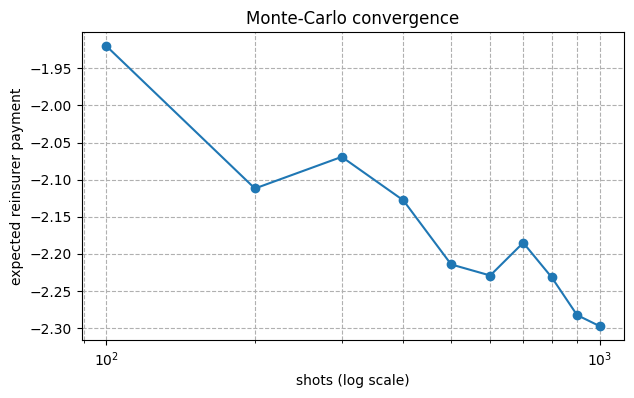

,shots,expected_payment
0,100.0,-1.920000
1,200.0,-2.112000
2,300.0,-2.069333
3,400.0,-2.128000
4,500.0,-2.214400
5,600.0,-2.229333
6,700.0,-2.185143
7,800.0,-2.232000
8,900.0,-2.282667
9,1000.0,-2.297600


In [ ]:
df_conv = convergence_study(qc,
                            payout_idx=payout_idx,
                            c_param=c_param,
                            coins=coins,
                            shot_grid=np.linspace(100, 1_000, 10))
# Save for later comparison, if you like
df_conv.to_csv("mc_convergence.csv", index=False)
df_conv

## Classical Monte Carlo

In [ ]:
import scipy.stats as stats

np.random.seed(42)  # For reproducibility

cmc_samples = 100_000

cmc_results = np.zeros(cmc_samples)
cmc_results_0_10 = np.zeros(cmc_samples)
for i in range(cmc_samples):
    # Sample lognormal
    lnorm = stats.lognorm.rvs(sigma, loc=0, scale=np.exp(mu))

    # Calculate payout
    payout = 0 if lnorm <= 1 else lnorm - (1 - coins) * (lnorm - deductible) - deductible
    
    # Store the results
    cmc_results[i] = payout

    # Calculate clipped payout on [0, 10]
    lnorm_0_10 = lnorm if lnorm <= 10 else 10
    payout_0_10 = 0 if lnorm_0_10 <= 1 else lnorm_0_10 - (1 - coins) * (lnorm_0_10 - deductible) - deductible
    cmc_results_0_10[i] = payout_0_10


C:\Users\alexf\AppData\Local\Temp\ipykernel_80720\775231159.py:18: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.axis([0, None, 0, None])


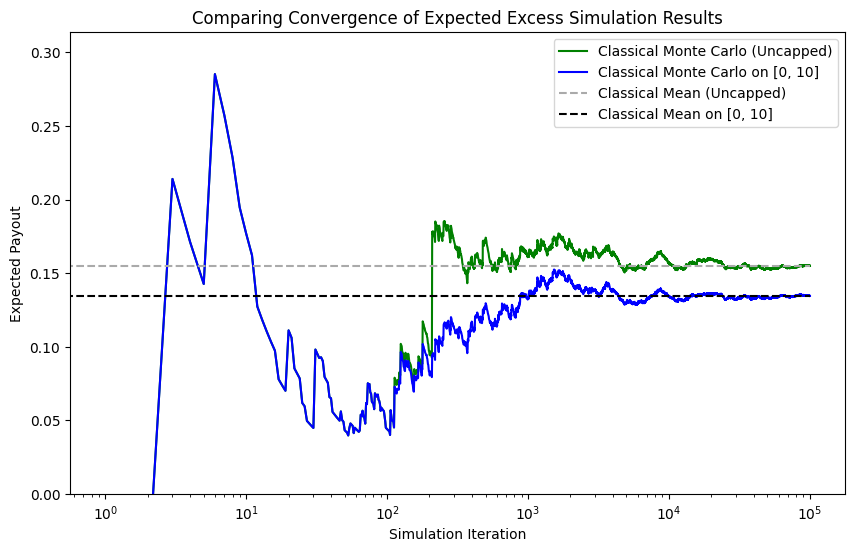

In [ ]:
cmc_running_mean = np.cumsum(cmc_results) / np.arange(1, len(cmc_results) + 1)
cmc_running_mean_0_10 = np.cumsum(cmc_results_0_10) / np.arange(1, len(cmc_results_0_10) + 1)
cmc_x = range(cmc_samples)

# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
plt.plot(cmc_x, cmc_running_mean, 'g-', label='Classical Monte Carlo (Uncapped)')
plt.plot(cmc_x, cmc_running_mean_0_10, 'b-', label='Classical Monte Carlo on [0, 10]')
# plt.plot(df_conv["shots"], df_conv["expected_payment"], 'r-', label='Quantum Monte Carlo on [0, 10]')
plt.hlines(y=cmc_running_mean[-1], xmin=0, xmax=cmc_samples, color='#aaaaaa', linestyle='--', label='Classical Mean (Uncapped)')
plt.hlines(y=cmc_running_mean_0_10[-1], xmin=0, xmax=cmc_samples, color='k', linestyle='--', label='Classical Mean on [0, 10]')
plt.legend(loc='best')
plt.title('Comparing Convergence of Expected Excess Simulation Results')
plt.xlabel('Simulation Iteration')
plt.ylabel('Expected Payout')
plt.ylim(0, 1.1 * max(np.max(cmc_running_mean), np.max(cmc_running_mean_0_10)))
plt.xscale('log', base=10)
plt.axis([0, None, 0, None])
plt.show()

In [ ]:
cmc_running_mean[-1]

np.float64(0.15505264360154886)

In [ ]:
cmc_running_mean_0_10[-1]

np.float64(0.13465517755970566)

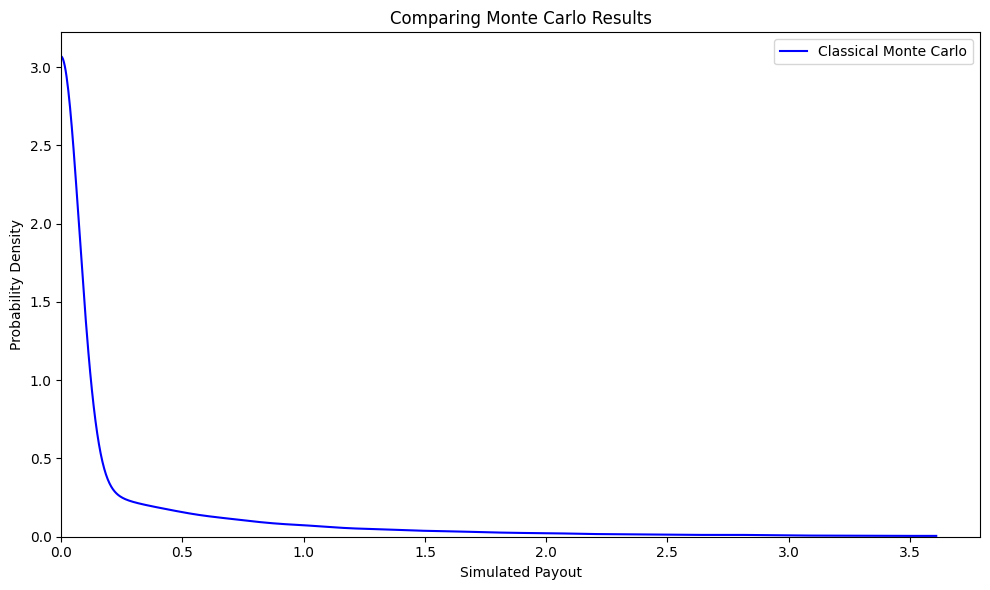

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
cmc_results_kde = stats.gaussian_kde(cmc_results)
cmc_x = np.linspace(0, np.percentile(cmc_results, 99) * 1.1, 1000)
plt.plot(cmc_x, cmc_results_kde(cmc_x), 'b-', label='Classical Monte Carlo')
# plt.plot(cmc_x, cmc_results_kde(cmc_x), 'r--', label='Quantum Monte Carlo')
plt.legend(loc='best')
plt.title('Comparing Monte Carlo Results')
plt.xlabel('Simulated Payout')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()